In [64]:
import cv2
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')


from commonfunctions import *
from classifiers import *
from stemRemoval import stemRemoval
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from skimage import morphology
from skimage.measure import find_contours
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin, binary_opening
from skimage.feature import match_template
import numpy as np
from staffLine import *
from skimage.feature import canny
from skimage.transform import hough_ellipse, resize
from skimage.draw import ellipse_perimeter
from skimage.transform import rescale

from skimage.draw import polygon_perimeter
from skimage.util import crop
import matplotlib.patches as patches
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage import color


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


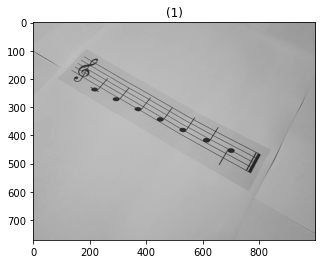

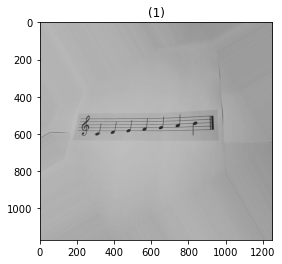

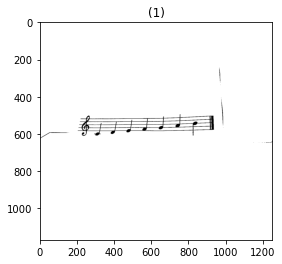

In [65]:
img = rgb2gray(io.imread('../dataset/cam/28.jpg'))

height, width = img.shape
scaleFactor = min(1000/height, 1000/width)
if scaleFactor > 1:
    scaleFactor = 1
img = rescale(img, scaleFactor, anti_aliasing=False)
show_images([img])
imgOutput = []
if img.dtype != np.uint8:
    noisy_img = (img * 255).astype(np.uint8)
img_median_filtered = hybridMedian(noisy_img)
img_median_filtered = img_median_filtered.astype(np.uint8)
# img_median_filtered = median(noisy_img)
# gaussian filtering
img_gaussian_filtered = gaussian(img_median_filtered, sigma=0.2)
img_gaussian_filtered = (img_gaussian_filtered * 255).astype(np.uint8)

# image rotation
image_rotated = skew_angle_hough_transform(img_gaussian_filtered)
image_rotated = (image_rotated * 255).astype(np.uint8)
show_images([image_rotated])
# image binarization
binary = adaptiveThresh(image_rotated, t=15, div=8)
show_images([binary])

[ 86 147 205 262 317]


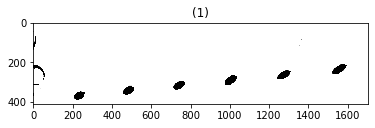

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


error: OpenCV(4.5.1) /tmp/pip-req-build-jr1ur_cf/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [68]:
# removing stafflines
img_staffLines_removed, staffLines, staffLineSpacing, staffHeight = staffLineRemoval(
    binary, 1)
show_images([img_staffLines_removed])

# clipping the unnecessary part before the real music score
start_x = get_start_x(binary, len(staffLines), staffHeight)
binary_clipped = binary[:, start_x:img_staffLines_removed.shape[1]]
img_staffLines_removed_clipped = img_staffLines_removed[:,start_x:img_staffLines_removed.shape[1]]
io.imsave("test.PNG",img_staffLines_removed)
# split each object in the score to be identified
objects = split_objects(
    binary_clipped, img_staffLines_removed_clipped, staffLines)

# templates to be used to classify the reltively short symbols with SIFT
templates = read_all_templates()


show_images([img_staffLines_removed])


11


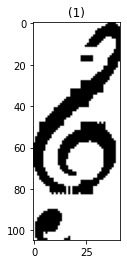

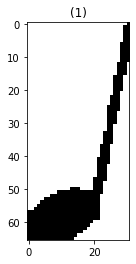

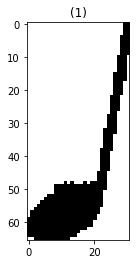

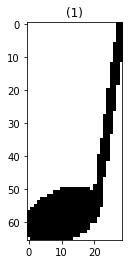

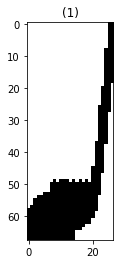

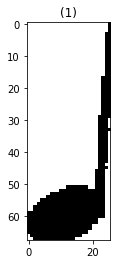

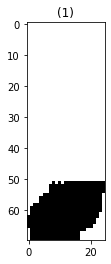

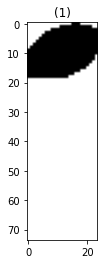

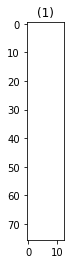

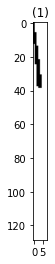

[['d1/1.', 'c2/4', 'e2/4']]


In [67]:
# if the score had multiple groups we divide them into blocks that have 5 stafflines
sameBlock = objects[0][2]
# each block has different pitches coordinates
pitches, pitches_coord = getPitchesCoordinates(
    staffLineSpacing, staffLines, sameBlock)
imgOutput = []
imgOutput.append([])
accidentals = ""
number = 0
two = False
print(len(objects))
for object, top, blockNumber, dots in objects:
    # if the we entered a new block recalculte the pitches coordinates
    if sameBlock != blockNumber:
        imgOutput.append([])
        sameBlock = blockNumber
        pitches, pitches_coord = getPitchesCoordinates(
            staffLineSpacing, staffLines, blockNumber)

    # classify the relatively short symbols using SIFT
    if len(object) < 3.5*staffLineSpacing:
        objectLabel, objectType = classify_accidentals(
            (object, top, blockNumber), templates, staffLineSpacing)
        if objectType == "accidental":
            accidentals += objectLabel
        if objectLabel == 'full_note':
            pitch = pitches[find_nearest(
                pitches_coord, top + len(object)/2)]
            objectLabel = pitch[0] + accidentals + pitch[1] + '/1'
            accidentals = ''
            objectLabel = objectLabel + '.' * dots
            imgOutput[-1].append(objectLabel)
        if objectType == "number":
            number = number + 1
            if objectLabel == "2":
                two = True
        if number == 2:
            if two == True:
                imgOutput[-1].append('\meter<"4/2">')
            else:
                imgOutput[-1].append('\meter<"4/4">')
            two = False
            number = 0
        continue
    objectWithouStem, stems = stemRemoval(object, staffLineSpacing)
    show_images([objectWithouStem])
    if len(stems) == 0:
        continue
    elif len(stems) == 1:
        note = ChordsClassifier(
            objectWithouStem, top, staffLineSpacing, pitches, pitches_coord)
        if note != '':
            imgOutput[-1].append(note)
            continue
        note = classifierA(objectWithouStem, stems, staffLineSpacing,
                            staffHeight, top, pitches, pitches_coord, dots, accidentals)
        if note != '':
            imgOutput[-1].append(note)
            accidentals = ""
    else:
        if chordOrBeamCheck(objectWithouStem) == 'chord':
            note = ChordsClassifier(
                object, top, staffLineSpacing, pitches, pitches_coord)
            if note != '':
                imgOutput[-1].append(note)
        else:
            notes = beamClassifier(object, objectWithouStem, staffLineSpacing,
                                    staffHeight, top, pitches, pitches_coord, stems)
            imgOutput[-1].extend(notes)
print(imgOutput)

In [14]:
for object in objects:
    staffLineSpacing = 20
    testNoStem, stems = stemRemoval(object, 20)
    print('stems (positions, widths) found: ', stems)
    another = np.copy(object)
    orig = np.copy(object)
    object = 255 - object
    height, width = object.shape
    horiz_proj = (np.sum(object/255, axis=1)).astype('uint32')
    vert_proj = (np.sum(object/255, axis=0)).astype('uint32')


    # visualize the horizontal projection
    m = np.max(horiz_proj, initial=0)
    if m == 0:
        m = 1
    result = np.zeros((height,width))
    # Draw a line for each row
    for row in range(height):
        cv2.line(result, (0,row), (int(horiz_proj[row]*width/m),row), 255, 1)

    # visualize the vertical projection
    m = np.max(vert_proj, initial=0)
    if m == 0:
        m = 1
    result2 = np.zeros((height, width))
    
    # thresholding to remove non stems from the image in the vertical projection for visualisation
    max_vertical = 0.8 * m
    vert_proj = np.where(vert_proj <= max_vertical, 0, vert_proj)
    mask = np.where(vert_proj!=0, 1, 0)
    # Draw a line for each row
    for col in range(width):
        cv2.line(result2, (col,0), (col,int(vert_proj[col]*height/m)), 255, 1)


    # Perform the distance transform algorithm
    # dist = cv2.distanceTransform(object, cv2.DIST_L1, 5)
    # max = dist.max()
    # # dist = np.where(dist < max, 0, 255)

    # # dist=cv2.distanceTransform(255-object,cv2.DIST_L2,3)
    # cv2.normalize(dist,dist,0,1.0,cv2.NORM_MINMAX)
    # _,mv,_,mp = cv2.minMaxLoc(dist)
    # #print(mv*2, mp) # (half)width*2, pos
    # draw = cv2.cvtColor(object, cv2.COLOR_GRAY2BGR)
    # cv2.line(draw, (0,mp[1]), (object.shape[1],mp[1]), (0,0,200), 3, -1)
    
    stems = np.nonzero(mask)[0]

    mask = np.array([mask,]*height) * 255
    # another method to remove the stems
    if height != 0:
        another = another+mask
        se = np.zeros((3,3))
        se[se.shape[0]//2+1, :] = 1 
        # to remove the excess due to the stem removals
        another = binary_closing(another, se)

    show_images([orig, another, result, result2, testNoStem], ['original', 'stem removal approach2', 'horizontal projection', 'vertical projection of stems and larger objects', 'stem removal approach1'])

ValueError: not enough values to unpack (expected 2, got 1)

In [6]:
gray = thresh
edges = cv2.Canny(gray,50,150,apertureSize = 3)
cv2.imwrite('edges-50-150.jpg',edges)
minLineLength=100
lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)

a,b,c = lines.shape
for i in range(a):
    x = lines[i][0][0] - lines [i][0][2]
    y = lines[i][0][1] - lines [i][0][3]
    if x!= 0:
        if abs(y/x) <1:
            cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 255, 255), 1, cv2.LINE_AA)

se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (4,4))
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, se)
gray = np.where(gray % 255, 0, gray)
gray =1- morphology.binary_dilation(255 - gray, np.ones((11,3)))
#gray = 1 - skeletonize(gray)

# height, width = gray.shape
# for i in range(height):
#     for j in range(width):
#         if (gray[i, j] != 0 and gray[i,j] != 255):
#             print(gray[i,j]) 

io.imsave('houghlines.png', gray.astype('float64'))
show_images([gray])


output = gray
# Find contours at a constant value of 0.8
contours = find_contours(output, 0.8)

fig, ax = plt.subplots()
ax.imshow(output, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

NameError: name 'thresh' is not defined

# testing for image prespective view

In [55]:
realImg = io.imread("../dataset/wraped.jpg", as_gray=True)
realImg = skew_angle_hough_transform(realImg)

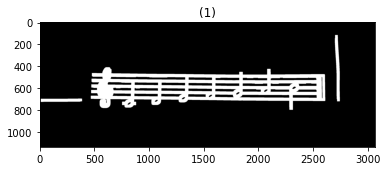

[[[ 603  411]]

 [[ 602  412]]

 [[ 600  412]]

 [[ 599  413]]

 [[ 598  413]]

 [[ 597  414]]

 [[ 596  414]]

 [[ 592  418]]

 [[ 591  418]]

 [[ 588  421]]

 [[ 588  422]]

 [[ 586  424]]

 [[ 586  425]]

 [[ 585  426]]

 [[ 585  427]]

 [[ 582  430]]

 [[ 582  431]]

 [[ 579  434]]

 [[ 579  435]]

 [[ 578  436]]

 [[ 578  437]]

 [[ 577  438]]

 [[ 577  440]]

 [[ 576  441]]

 [[ 576  442]]

 [[ 574  444]]

 [[ 574  445]]

 [[ 573  446]]

 [[ 573  449]]

 [[ 572  450]]

 [[ 572  451]]

 [[ 571  452]]

 [[ 571  455]]

 [[ 570  456]]

 [[ 570  464]]

 [[ 569  465]]

 [[ 518  465]]

 [[ 517  464]]

 [[ 475  464]]

 [[ 474  465]]

 [[ 474  492]]

 [[ 475  493]]

 [[ 480  493]]

 [[ 481  494]]

 [[ 481  497]]

 [[ 568  497]]

 [[ 569  496]]

 [[ 570  497]]

 [[ 570  502]]

 [[ 571  503]]

 [[ 571  505]]

 [[ 572  506]]

 [[ 572  512]]

 [[ 573  513]]

 [[ 573  515]]

 [[ 572  516]]

 [[ 516  516]]

 [[ 515  515]]

 [[ 473  515]]

 [[ 472  516]]

 [[ 471  516]]

 [[ 471  543]]

 [[ 472 

In [56]:

from skimage import feature, filters
from skimage import transform as tf
from skimage import data
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
import imutils

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
	 # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped


x = img_as_ubyte(realImg > 0.5)
height, width = realImg.shape
img = feature.canny(realImg)
img_closed = binary_dilation(img, np.ones((25, 25)))
x = img_as_ubyte(img_closed)
show_images([x])
# Find contours at a constant value of 0.8
# contours = find_contours(img_closed, 0.8)
# fig, ax = plt.subplots()
# ax.imshow(img_closed, cmap=plt.cm.gray)
#--- Find the contours ---

cnts = cv2.findContours(x.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
print(c)
y = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])
print(extLeft)
print(extBot)
print(extTop)
print(extRight)




(464, 696)
(2281, 798)
(633, 411)
(2607, 715)
[2281, 798]
[633, 411]
[2105, 426]
[576, 782]


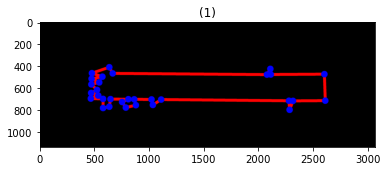

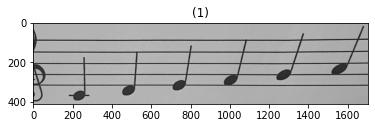

In [63]:
y = cv2.cvtColor(realImg.astype('uint8'), cv2.COLOR_GRAY2RGB)
epsilon = 0.005*cv2.arcLength(c,True)
approx = cv2.approxPolyDP(c,epsilon,True)

extLeft = tuple(approx[approx[:, :, 0].argmin()][0])
extRight = tuple(approx[approx[:, :, 0].argmax()][0])
extTop = tuple(approx[approx[:, :, 1].argmin()][0])
extBot = tuple(approx[approx[:, :, 1].argmax()][0])

print(extLeft)
print(extBot)
print(extTop)
print(extRight)

bl = [-1, 0]
br = [-1, 0]
tr = [-1, height]
tl = [-1, height]
for point in approx:
    pointx = point[0][0]
    pointy = point[0][1]
    if pointx > width // 2:
        if pointy > br[1]:
            br = [pointx,pointy]
        if pointy < tr[1]:
            tr = [pointx,pointy]
    else:
        if pointy > bl[1]:
            bl = [pointx,pointy]
        if pointy < tl[1]:
            tl = [pointx,pointy]
            
print(br)
print(tl)
print(tr)
print(bl)

cv2.circle(y, tuple(br), 30, (255, 255, 0), -1)
cv2.circle(y, tuple(tl), 30, (255, 255, 0), -1)
cv2.circle(y, tuple(tr), 30, (255, 255, 0), -1)
cv2.circle(y, tuple(bl), 30, (255, 255, 0), -1)
cv2.drawContours(y, [approx], -1, (255, 0, 0), 25)
for point in approx:
    cv2.circle(y, tuple(point[0]), 30, (0, 0, 255), -1)
pts = np.array([tuple(br), tuple(tl), tuple(tr), tuple(bl)], dtype = "float32")
show_images([y])
wraped = four_point_transform(realImg, pts)
show_images([wraped])



In [ ]:
def getHoughLines(imgFile):
    img = cv2.imread(imgFile)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150,apertureSize = 3)

    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

    cv2.imwrite("gray.png", img)

def removeLinesFromSheet(imgFile):

    img = cv2.imread(imgFile)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    adaptiveThreshHoldImage = adaptiveThresh(~gray, 15, 8)

    cv2.imwrite("adaptive.png", adaptiveThreshHoldImage)

    horizontal = adaptiveThreshHoldImage.copy()
    vertical = adaptiveThreshHoldImage.copy()

    (rows, cols) = adaptiveThreshHoldImage.shape

    horizontalSize = cols//30
    verticalSize = rows//30

    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT,(horizontalSize, 1))

    horizontal = cv2.erode(horizontal, horizontalStructure, iterations = 1)
    horizontal = cv2.dilate(horizontal, horizontalStructure, iterations = 1)

    cv2.imwrite("horizontal.png", horizontal)

    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT,(1, 3))

    vertical = cv2.erode(vertical, verticalStructure, iterations = 1)
    vertical = cv2.dilate(vertical, verticalStructure, iterations = 1)

    vertical = cv2.bitwise_not(vertical)

    cv2.imwrite("verical.png", vertical)

    smoothedThreshHoldImg = cv2.adaptiveThreshold(vertical, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -2)

    cv2.imwrite("edges.png", smoothedThreshHoldImg)
    cv2.imwrite("bitwise.png", horizontal)
    output = adaptiveThreshHoldImage - horizontal
    cv2.imwrite("output.png", output)
    return output

def read_staff_lines(img):
	edges = cv2.Canny(img,150,700)

	lines = cv2.HoughLines(edges,1,np.pi/180,200)
	staff_lines = []
	for rho,theta in lines[0]:
	    a = np.cos(theta)
	    b = np.sin(theta)
	    x0 = a*rho
	    y0 = b*rho
	    x1 = int(x0 + 1000*(-b))
	    y1 = int(y0 + 1000*(a))
	    x2 = int(x0 - 1000*(-b))
	    y2 = int(y0 - 1000*(a))

	    th = 10 #pixels
	    too_close = False

	    # only appends lines if they're a reasonable distance
	    # from other lines
	    # would be better if used averaging between close lines instead of
	    # just taking the first one we see and tossing the other
	    for y in staff_lines:
	      	if abs(y - y1) <= th:
	    	    too_close = True
	    if not too_close:
	    	staff_lines.append((y1))

	return staff_lines
path = "./dataset/multiple_lines_scanned.png"
getHoughLines(path)
thresholded = removeLinesFromSheet(path)
output = thresholded
se = np.ones((3,3))
# se[1,: ] = 1
# se[:, 1] = 1

#[[0, 1, 0],[1, 1, 1],[0, 1, 0]]
se = np.ones((4, 2))
output = morphology.binary_erosion(output, se)
se = np.ones((10,3))
output = morphology.binary_dilation(output, se)





# Find contours at a constant value of 0.8
contours = find_contours(output, 0.8)

fig, ax = plt.subplots()
ax.imshow(output, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()




io.imsave("output.png", 1-output.astype('float64'))
show_images([1-output])
#output = cv2.dilate(output, horizontalStructure, iterations = 1)


output file is not empty


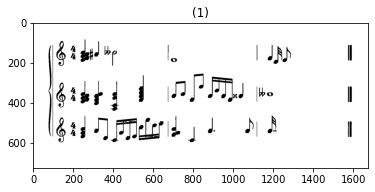

[['\\meter<"4/4">', '{a1/4,b1/4,e1/4,f1/4,g1/4}', 'a1/4', 'b&&1/2', 'e1/1', 'f1/4', 'd1/32', 'e1/8'], ['\\meter<"4/4">', '{a1/4,b1/4,e1/4,f1/4,g1/4}', '{a1/4,b1/4,d1/4,f1/4}', '{a0/4,b1/4,c1/4,g1/4}', '{a1/4,c2/4,e2/4,f1/4}', 'a1/8', 'b1/8', 'f1/8', 'f2/8', 'a1/16', 'd2/16', 'a1/16', 'f1/16', 'a##1/4', 'b&&1/1'], ['\\meter<"4/4">', '{b1/4,e1/4,g1/4}', 'a1/8', 'd1/8', 'g1/16', 'd1/32', 'e1/16', 'c2/16', 'g2/16', 'd2/16', 'e2/16', '{b1/4,f1/4,g1/4}', 'c1/4', 'a1/4.', 'a1/8', 'a1/32..']]


In [21]:
inputImagesDirectory = "../dataset/stress"
directory = os.fsencode(inputImagesDirectory)
inputImages = []
filenames = []
outputDirectory = '../outputs/'
try:
    if os.path.exists(outputDirectory) and os.path.isdir(outputDirectory):
        shutil.rmtree(outputDirectory)
    os.mkdir(outputDirectory)
except:
    print("output file is not empty")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    filenames.append(os.path.splitext(filename)[0])
    image = img_as_ubyte(io.imread(os.path.join(
        inputImagesDirectory, filename), as_gray=True))
    inputImages.append(image)

for imageIndex in range(len(inputImages)):
    imgOutput = []
    img = inputImages[imageIndex]

    img_median_filtered = hybridMedian(img).astype('uint8')
    # img_median_filtered = median(noisy_img)
    # gaussian filtering
    img_gaussian_filtered = img_as_ubyte(
        gaussian(img_median_filtered, sigma=0.2))

   # image rotation
    image_rotated = skew_angle_hough_transform(img_gaussian_filtered)
    image_rotated = (image_rotated * 255).astype(np.uint8)

    # image binarization
    binary = adaptiveThresh(image_rotated, t=15, div=8)

    # removing stafflines
    img_staffLines_removed, staffLines, staffLineSpacing, staffHeight = staffLineRemoval(
        binary, 1)

    # clipping the unnecessary part before the real music score
    start_x = get_start_x(binary, len(staffLines), staffHeight)
    binary_clipped = binary[:, start_x:img_staffLines_removed.shape[1]]
    img_staffLines_removed_clipped = img_staffLines_removed[:,
                                                            start_x:img_staffLines_removed.shape[1]]

    show_images([img_staffLines_removed])
    # split each object in the score to be identified
    objects = split_objects(
        binary_clipped, img_staffLines_removed_clipped, staffLines)
    # templates to be used to classify the reltively short symbols with SIFT
    templates = read_all_templates()

    # if the score had multiple groups we divide them into blocks that have 5 stafflines
    sameBlock = objects[0][2]

    # each block has different pitches coordinates
    pitches, pitches_coord = getPitchesCoordinates(
        staffLineSpacing, staffLines, sameBlock)
    imgOutput.append([])
    accidentals = ""
    number = 0
    two = False
    for object, top, blockNumber, dots in objects:
      # if the we entered a new block recalculte the pitches coordinates
        if sameBlock != blockNumber:
            imgOutput.append([])
            sameBlock = blockNumber
            pitches, pitches_coord = getPitchesCoordinates(
                staffLineSpacing, staffLines, blockNumber)

        # classify the relatively short symbols using SIFT
        if len(object) < 3.5*staffLineSpacing:
            objectLabel, objectType = classify_accidentals(
                (object, top, blockNumber), templates, staffLineSpacing)
            if objectType == "accidental":
                accidentals += objectLabel
            if objectLabel == 'full_note':
                pitch = pitches[find_nearest(
                    pitches_coord, top + len(object)/2)]
                objectLabel = pitch[0] + accidentals + pitch[1] + '/1'
                accidentals = ''
                objectLabel = objectLabel + '.' * dots
                imgOutput[-1].append(objectLabel)
            if objectType == "number":
                number = number + 1
                if objectLabel == "2":
                    two = True
            if number == 2:
                if two == True:
                    imgOutput[-1].append('\meter<"4/2">')
                else:
                    imgOutput[-1].append('\meter<"4/4">')
                two = False
                number = 0
            continue
        objectWithouStem, stems = stemRemoval(object, staffLineSpacing)
        if len(stems) == 0:
            continue
        elif len(stems) == 1:
            note = ChordsClassifier(
                objectWithouStem, top, staffLineSpacing, pitches, pitches_coord)
            if note != '':
                imgOutput[-1].append(note)
                continue
            note = classifierA(objectWithouStem, stems, staffLineSpacing,
                                staffHeight, top, pitches, pitches_coord, dots, accidentals)
            if note != '':
                imgOutput[-1].append(note)
                accidentals = ""
        else:
            if chordOrBeamCheck(objectWithouStem) == 'chord':
                note = ChordsClassifier(
                    object, top, staffLineSpacing, pitches, pitches_coord)
                if note != '':
                    imgOutput[-1].append(note)
            else:
                notes = beamClassifier(object, objectWithouStem, staffLineSpacing,
                                        staffHeight, top, pitches, pitches_coord, stems)
                imgOutput[-1].extend(notes)
    print(imgOutput)
    outputFileName = outputDirectory + filenames[imageIndex] + '.txt'
    writeOutput(outputFileName, imgOutput)